# Getting Started with QMCPy

This notebook gives a hands‑on tour of the QMCPy library, which is desined to support __low discrepancy (LD)__ sequences and __quasi-Monte Carlo (qMC)__ methods:

<ol start="-1">
  <li>Initialization and importing <code>qmcpy</code> as <code>qp</code></li>
  <li>Why not grids?</li>
  <li>The <code>DiscreteDistributions</code> class and low discrepancy generators on $\cu[0,1]^d$</li>
  <li>The <code>TrueMeasure</code> class for mimicking distributions that are not standard uniform</li>
  <li>Designing your <code>Integrand</code> for use with Monte Carlo </li>
  <li>Adaptive  <code>StoppingCriterion</code> class for determining when to stop the simulation based on the desired error tolerance</li>
  <li>An Asian option pricing example</li>
</ol>

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vu}{\boldsymbol{u}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vz}{\boldsymbol{z}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\mI}{\mathsf{I}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\hmu}{\widehat{\mu}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/QMCPy_Introduction.ipynb)

In [1]:
# Colab-only setup
if "google.colab" in str(get_ipython()):
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !pip install git+https://github.com/fjhickernell/HickernellClassLib.git@main

### -1. Import needed packages and initialize some parameters

In [2]:
# ----- Standard packages -----
import sys, math, time
from pathlib import Path
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import qmcpy as qp
import scipy as sp
import scipy.stats as stats
import pandas as pd
from typing import Callable, Dict, Any
from tqdm.auto import tqdm
from IPython.display import display, Markdown

if not hasattr(np, "math"):
    np.math = math

# ----- Import classlib: rely on env, but verify path -----
import classlib as cl
print("classlib path:", cl.__file__)

#these generators are not in qmcpy yet, but in out class library 
qp.Kronecker = cl.generators.Kronecker
qp.TensorProductGrid = cl.generators.TensorProductGrid

# ----- Plotting / Style -----
%matplotlib inline

cl.nbviz.init(use_tex=True)
colors, TINY = cl.nbviz.TOL_BRIGHT, cl.nbviz.TINY
cl.nbviz.configure(figpath="QMCPy_Intro_figures", savefigs=True)

print("QMCPy version:", qp.__version__)
display(Markdown("All classes from `qmcpy` are accessed as `qp.classname`"))

classlib path: /Users/fredhickernell/SoftwareRepositories/HickernellClassLib/classlib/__init__.py


QMCPy version: 2.0


All classes from `qmcpy` are accessed as `qp.classname`

## 0. Why not grids?
We often can write our problem as
$$
\mu = \int_{[0,1]^d} f(\vx) \dif \vx =?
$$
and we approximate $\mu$ by a sample mean,
$$
\hmu = \frac 1n \sum_{i=0}^{n-1} f(\vx_i)
$$

We know how to place points evenly in an interval, i.e., $d=1$.  E.g., the points 
$$
x_i = i/n, \quad i=0, \ldots, n-1
$$ 
are evenly spaced. 

However, when we want to work in dimension, $d$, greater than one, we have a _dilemma_.  Tensor product grids do not fill space well as we can see from the plots below.  For a $4$-dimensional grid of $n=256$ points we only have __four__ distinct values for each coordinate.

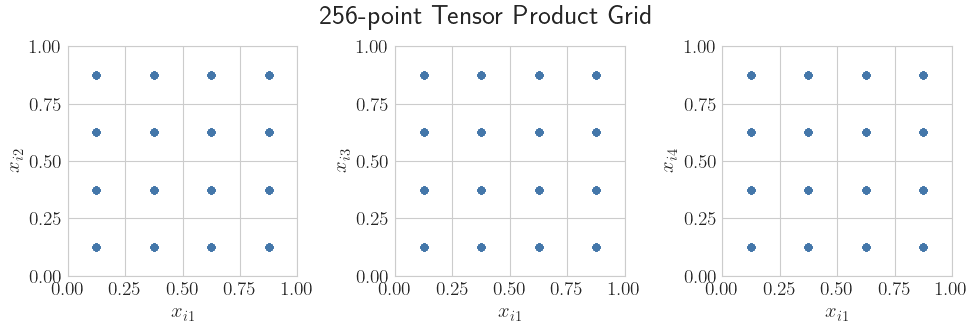

In [3]:
levels_per=4  #number of distinct values per coordinate
d=4  #dimension
grid_levels = [levels_per]*d  #list of levels per coordinate
grid = qp.TensorProductGrid(grid_levels)  #generate grid
fig, ax = qp.plot_proj(  #helper function to plot sample nodes
    grid,
    n=grid.n_total,
    d_horizontal=[1],
    d_vertical=[2,3,4],
    marker_size=20,
    figfac=10,
    where_title=0.545,
    fig_title=f"{grid.n_total}-point Tensor Product Grid",
)

We only see $16$ points in each two-dimensional projection.

## 1. Discrete distributions and low‑discrepancy (LD) points

A `DiscreteDistribution` object in QMCPy generates an $n\times d$ array of points in $[0,1)^d$:

- Rows = independent *samples*.
- Columns = *coordinates* (dimensions).

For IID sampling the rows are independent uniforms and there is no preferred ordering.
For LD sequences
- digital (Sobol' is the most well-known)
- lattices,
- Kronecker, and
- Halton,
the points are highly structured so that **every low‑dimensional projection looks well‑filled**.

### 1.1 Constructing and calling LD samplers
We first construct a dictionary of samplers for later use and then show the output from one.  This same syntax is used on the the `DiscreteDistribution` objects

In [6]:
x_sobol = qp.Sobol(dimension=5,randomize=False)(n=16)
print("This array of Sobol' points has shape", x_sobol.shape, "and the first several points are\n", x_sobol[:16])

This array of Sobol' points has shape (16, 5) and the first several points are
 [[0.     0.     0.     0.     0.    ]
 [0.5    0.5    0.5    0.5    0.5   ]
 [0.25   0.75   0.75   0.75   0.25  ]
 [0.75   0.25   0.25   0.25   0.75  ]
 [0.125  0.625  0.375  0.125  0.125 ]
 [0.625  0.125  0.875  0.625  0.625 ]
 [0.375  0.375  0.625  0.875  0.375 ]
 [0.875  0.875  0.125  0.375  0.875 ]
 [0.0625 0.9375 0.5625 0.3125 0.6875]
 [0.5625 0.4375 0.0625 0.8125 0.1875]
 [0.3125 0.1875 0.3125 0.5625 0.9375]
 [0.8125 0.6875 0.8125 0.0625 0.4375]
 [0.1875 0.3125 0.9375 0.4375 0.5625]
 [0.6875 0.8125 0.4375 0.9375 0.0625]
 [0.4375 0.5625 0.1875 0.6875 0.8125]
 [0.9375 0.0625 0.6875 0.1875 0.3125]]


You may see a _warning_ about the first point being the origin.  If this point is later transformed by the inverse Gaussian distribution then it becomes $-\boldsymbol{\infty}$, which can cause numerical problems.  We talk about how to avoid those problems later.

### 1.2 Visualizing projections with `plot_proj`

QMCPy includes a helper `plot_proj` that plots 2D projections of a `DiscreteDistribution`.
This is a quick way to *see* the difference between IID points and LD points.

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:421: ParameterWarning: Without randomization, the first digtial net point is the origin
  warnings.warn("Without randomization, the first digtial net point is the origin",ParameterWarning)
/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/lattice/lattice.py:248: ParameterWarning: Without randomization, the first lattice point is the origin
  warnings.warn("Without randomization, the first lattice point is the origin",ParameterWarning)
/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/halton.py:263: UserWarning: Without randomization, the first Halton point is the origin
  warnings.warn("Without randomization, the first Halton point is the origin")


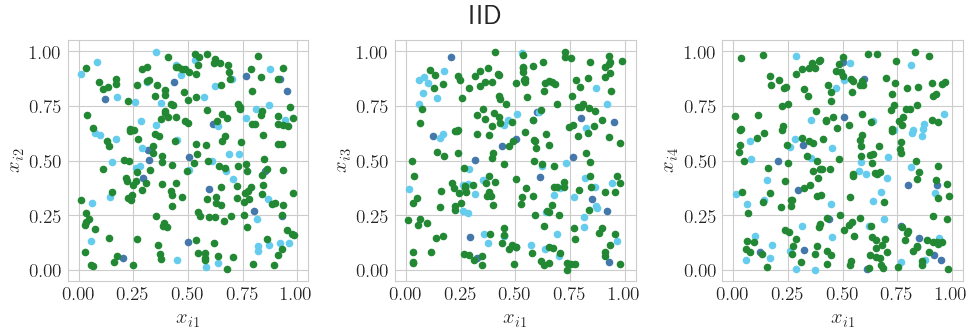

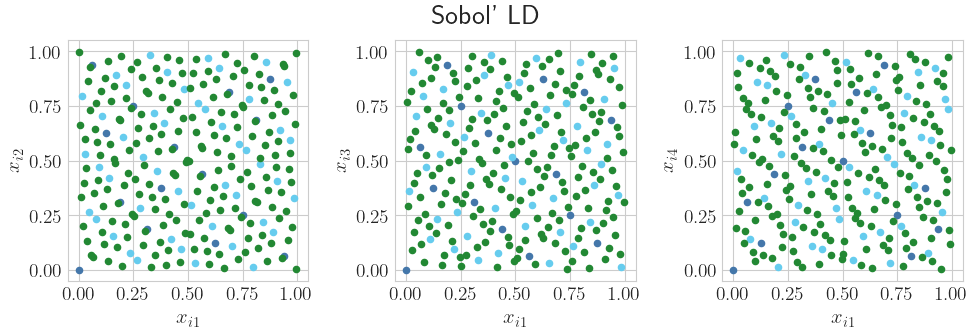

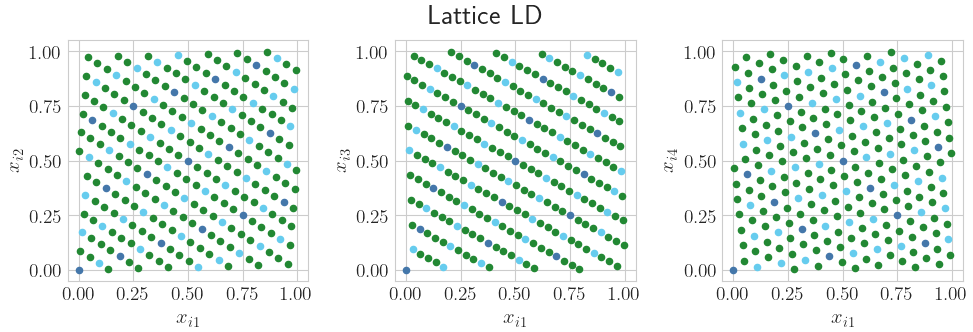

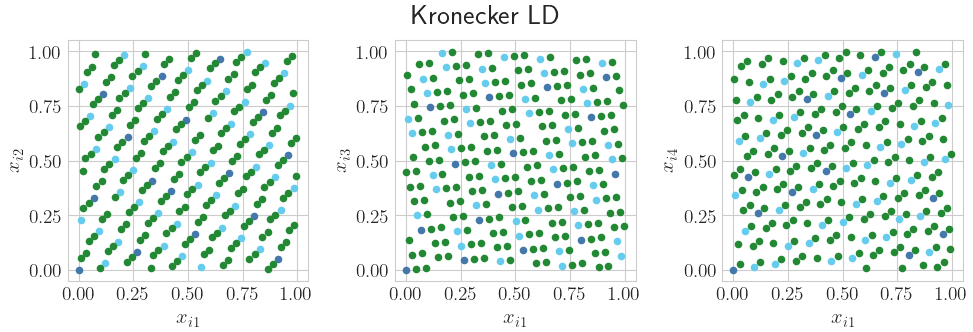

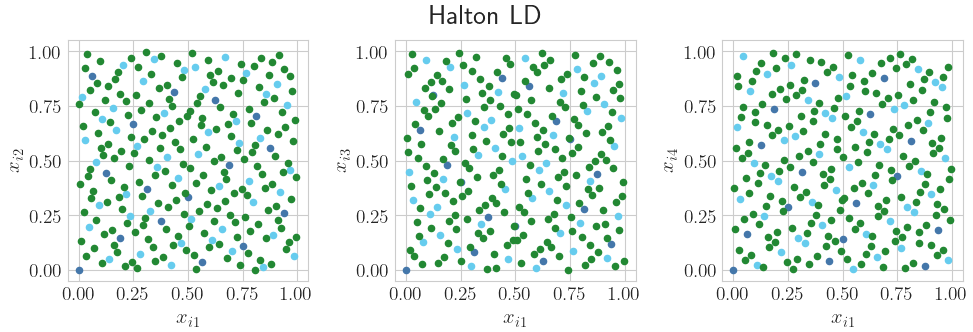

In [7]:
samplers = {  #these are samplers that we will use for our examples later
    "iid":       lambda d, random=True: {"gen": qp.IIDStdUniform(d),               "label": "IID"},
    "sobol":     lambda d, random=True: {"gen": qp.Sobol(d,randomize=random),      "label": "Sobol' LD"},
    "lattice":   lambda d, random=True: {"gen": qp.Lattice(d,randomize=random),    "label": "Lattice LD"},
    "kronecker": lambda d, random=True: {"gen": qp.Kronecker(d,randomize=random),  "label": "Kronecker LD"},
    "halton":    lambda d, random=True: {"gen": qp.Halton(d,randomize=random),     "label": "Halton LD"}
}

d=4
the_samplers = {name: key(d, False) for name, key in samplers.items()} #initialize samplers with d and no randomization
n_plot = [16, 64, 256]  #list of sample sizes to plot
d_horiz = 1  #coordinate(s) for the horizontal axis or axes
d_vert = [2, 3, 4]  #coordinates for the vertical axis or axes

for key, s in the_samplers.items():
    fig, ax = qp.plot_proj(
        s["gen"],
        n=n_plot,
        d_horizontal=d_horiz,
        d_vertical=d_vert,
        axis_pad=0.05,
        marker_size=20,
        figfac=10,  #how big do you want your figures
        fig_title=s["label"],
        where_title=0.545,  #for some reason, this has to be fiddled with to look nice
    )
    cl.nbviz.savefig(s["label"])


Points numbered 0 to 15 are <span style="color:#4477AA; font-size:200%; position:relative; top:3px;">•</span>. Points numbered 16 to 63 are <span style="color:#66CCEE; font-size:200%; position:relative; top:3px;">•</span>.  Points numbered 64 to 255 are <span style="color:#228833; font-size:200%; position:relative; top:3px;">•</span>.  As the sample size increases the points fill the unit cube.  

- In contrast to the four-dimensional grid, these LD points have great two-dimensional projections.
- IID points are better than grids in four dimensions, but worse than LD.

### 1.3 Get the rows and columns right
Note that all `DiscreteDistribution` generators return arrays of shape `(n=sample size, d=dimension)`.

For LD sequences like Sobol' and lattice, Halton, and Kronecker, *which column is which coordinate matters*:

- Column 0 always holds the first coordinate $x_{i1}$ of every sample, $\vx_i$.
- Column 1 always holds the second coordinate $x_{i2}$, of every sample, $\vx_i$, etc.

If we plot the transpose of an IID array it looks similar, but the transpose of an LD array does not look so nice.

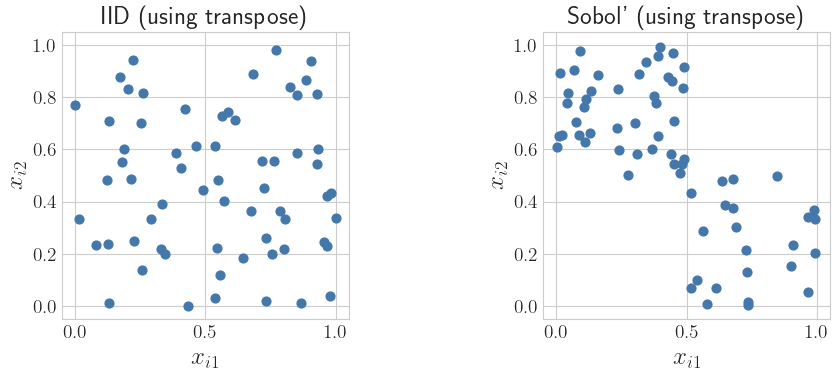

In [16]:
n, d = 64, 64
# Correctly shaped samples: shape (n, d)
x_iid   = qp.IIDStdUniform(d)(n)
x_sobol = qp.Sobol(d,randomize=False)(n)

# Now "confuse" dimensions: transpose so shape (d, n)
x_iid_T   = x_iid.T
x_sobol_T = x_sobol.T

coord_horiz = 0
coord_vert = 1
# Treat rows as points and columns as coordinates:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x_iid_T[:, coord_horiz], x_iid_T[:, coord_vert], s=40)
axes[0].set_title("IID (using transpose)")
axes[1].set_title("Sobol' (using transpose)")
axes[1].scatter(x_sobol_T[:, coord_horiz], x_sobol_T[:, coord_vert], s=40)
for ax in axes:
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(rf"$x_{{i{coord_horiz+1}}}$")
    ax.set_ylabel(rf"$x_{{i{coord_vert+1}}}$")
plt.tight_layout()

Since the original Sobol' points are $\vx_0 = (0, \ldots, 0)$ and $\vx_1 = (0.5, \ldots, 0.5)$, the $64$ points using the transpose are all the same, i.e., $64$ copies of $(0,0.5)$.

The LD construction is designed so that

- the _low-dimensional_ projections of _lower-numbered_ coordinates are very evenly spread,
- while higher-dimensional projections and/or projections of higher numbered coordinates may be less evenly spread.

Thus, when possible, it is better to construct your function, $f$, to depend more on lower-dimensional projections and more on lower-numbered coordinates.

By contrast, for IID points the evenness is not as good as low discepancy points, their performance does not depend on which coordinate you are looking at.  Here we show some larger dimensions for IID and Sobol'

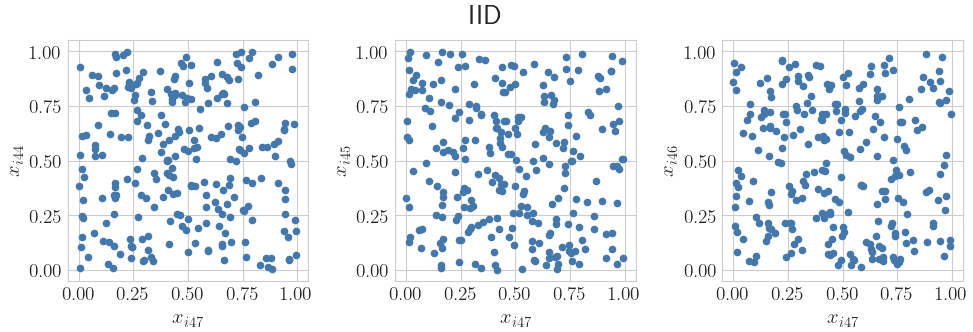

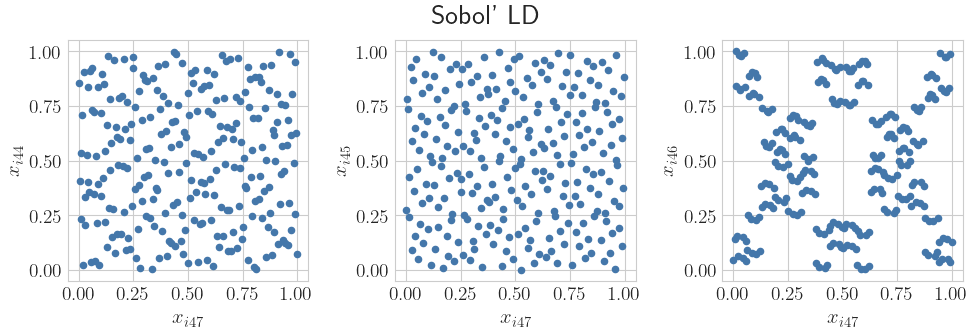

In [13]:
d=47
the_samplers = {name: key(d, False) for name, key in samplers.items()} #initialize samplers with d and no randomization
n_plot = [256]  #list of sample sizes to plot
d_horiz = 47  #coordinate(s) for the horizontal axis or axes
d_vert = [44, 45, 46]  #coordinates for the vertical axis or axes

keys_to_plot = ["iid", "sobol"]
for key in keys_to_plot:
    s = the_samplers[key]
    fig, ax = qp.plot_proj(
        s["gen"],
        n=n_plot,
        d_horizontal=d_horiz,
        d_vertical=d_vert,
        axis_pad=0.05,
        marker_size=20,
        figfac=10,  #how big do you want your figures
        fig_title=s["label"],
        where_title=0.545,  #for some reason, this has to be fiddled with to look nice
    )
    cl.nbviz.savefig(s["label"])

Notice that the IID figures look about the same as above, but the Sobol' sampling does not look quite as good for some two-dimensional projections.

### 1.4 Randomize to get points of the boundary

All of these LD samples can be randomized 
* To make
$ \displaystyle
\hmu = \frac 1n \sum_{i=0}^{n-1} f(\vx_i)
$
an unbiased estimator for $\mu$, and
* To ensure that nodes do not lie on the boundary of the unit cube.

These randomizations take the form of
* Random shifts modulo one for lattice, Kronecker, and Halton,
* Random digital shifts plus linear matrix or nested uniform scrambling of the digits of digital nets and Halton.
These randomizations preserve the LD structure.

We encourage that the `randomization` logical argument be left as its default, which is True. Here are some pictures of randomized LD sequences.

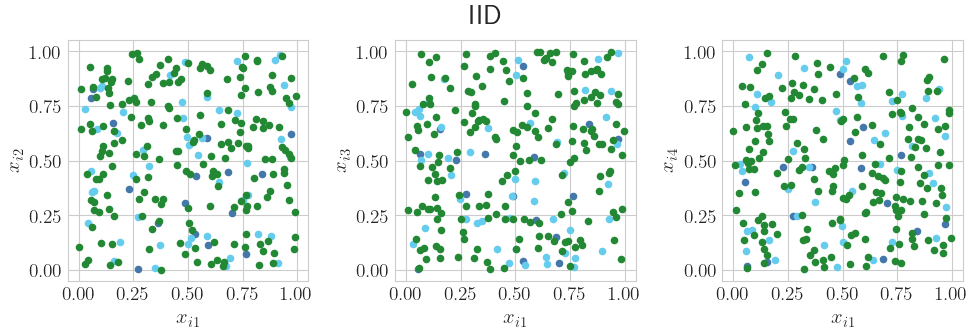

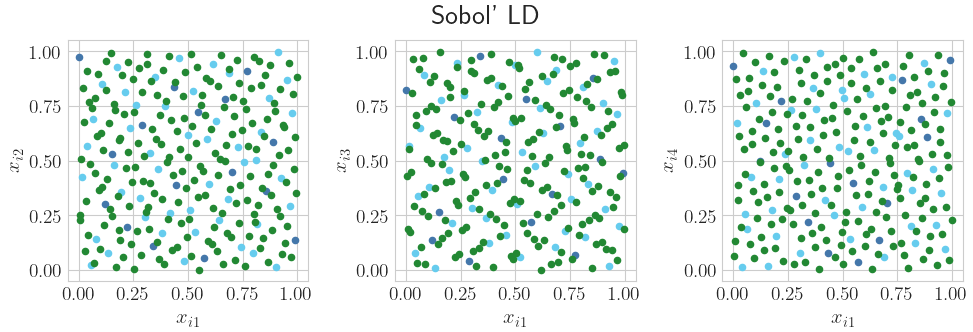

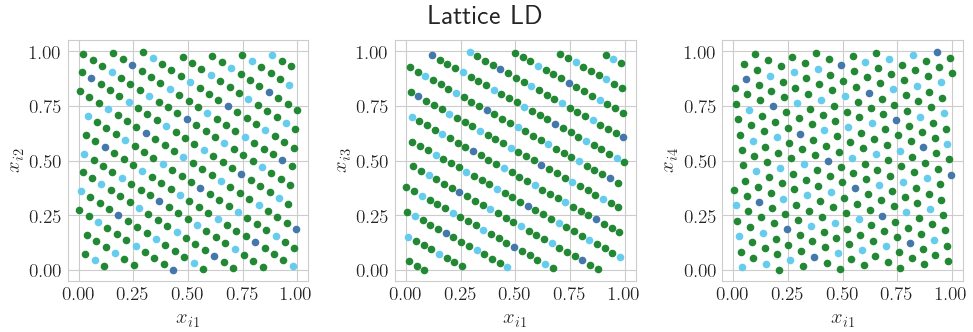

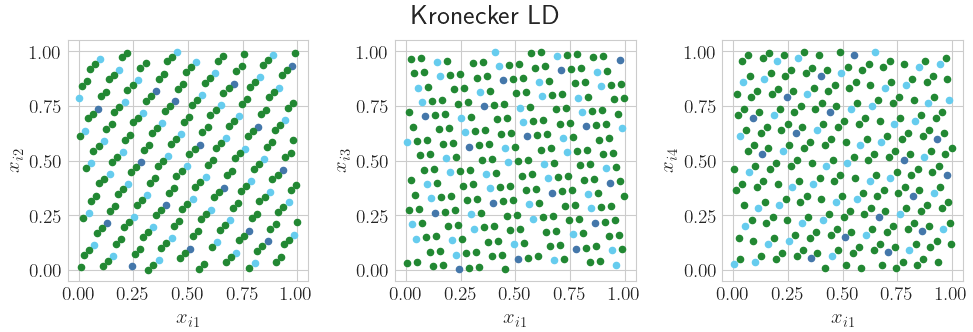

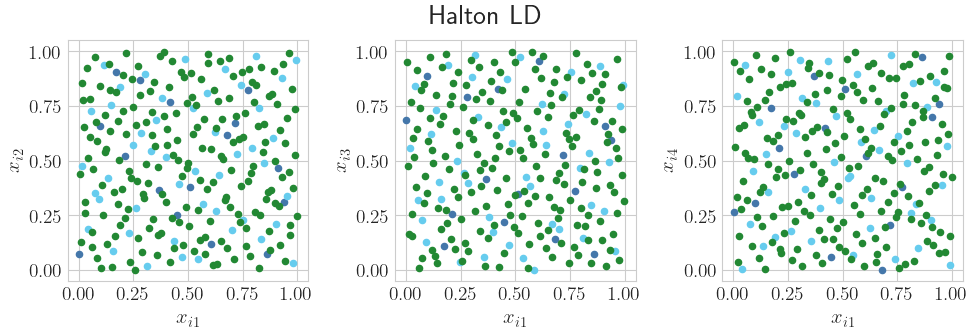

In [12]:
d=4
the_samplers = {name: key(d) for name, key in samplers.items()} #initialize samplers with d and randomization
n_plot = [16, 64, 256]  #list of sample sizes to plot
d_horiz = 1  #coordinate(s) for the horizontal axis or axes
d_vert = [2, 3, 4]  #coordinates for the vertical axis or axes

for key, s in the_samplers.items():
    fig, ax = qp.plot_proj(
        s["gen"],
        n=n_plot,
        d_horizontal=d_horiz,
        d_vertical=d_vert,
        axis_pad=0.05,
        marker_size=20,
        figfac=10,  #how big do you want your figures
        fig_title=s["label"],
        where_title=0.545,  #for some reason, this has to be fiddled with to look nice
    )

## 2. From uniform to other distributions: `TrueMeasure`

A `DiscreteDistribution` generates points in $[0,1)^d$ that *mimic* a base distribution (usually standard uniform).
A `TrueMeasure` wraps a discrete distribution and transforms its points so that they mimic another distribution, such as a Gaussian or Exponential.

Conceptually:

1. Start with LD points $\boldsymbol{u}_i \in [0,1)^d$
2. Apply a transformation $\boldsymbol{\Psi}: [0,1)^d \to \mathcal{X}$, where $\mathcal{X}$ is the sample space of the desired distribution (e.g., inverse Gaussian CDF) to get $\boldsymbol{x}_i = \boldsymbol{\Psi}(\boldsymbol{u}_i)$
   - This may be done coordinate-wise or
   - In the case of multivariate Gaussian, as coordinate-wise and then a linear transformation
4. Use the transformed points ${\boldsymbol{x}_i}$ to approximate expectations with respect to the new distribution

### Multivariate Gaussian

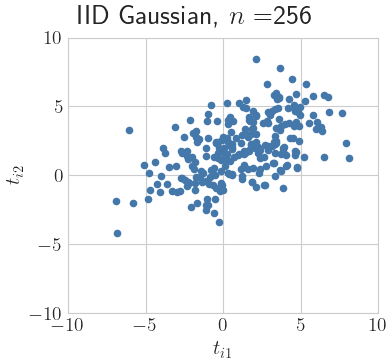

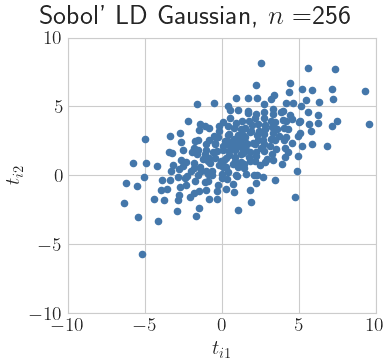

In [17]:
d = 2
the_samplers = {name: key(d) for name, key in samplers.items()} #initialize samplers with d and randomization
n = 2**8
keys_to_plot = ["iid", "sobol"]
for key in keys_to_plot:
    s = the_samplers[key] 
    # Wrap the base sampler in a Gaussian transformation
    gaussian = qp.Gaussian(s["gen"], mean=[1, 2], covariance=[[9, 4],[4, 5]])

    fig, ax = qp.plot_proj(
        gaussian,
        n=n,
        d_horizontal=1,
        d_vertical=2,
        axis_pad=0.05,
        marker_size=20,
        figfac=4,  # how big do you want your figures
        fig_title=f"{s['label']} Gaussian, $n=${n}",
        where_title=0.93,
    )
    ax[0,0].set_xlim([-10,10])
    ax[0,0].set_ylim([-10,10])

### SciPy Distributions
We can also harness the distributions in `scipy`, which allows different distributions for each marginal.  Here the first coordinate is $\mathcal{U}[0,10]$ and the second coordinate is $\text{Exp}(1/7)$.

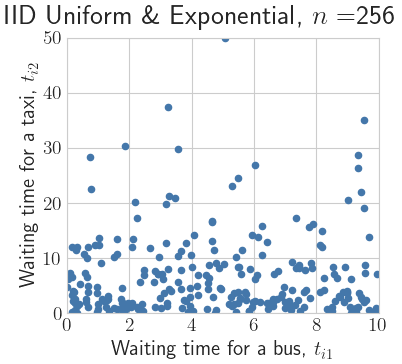

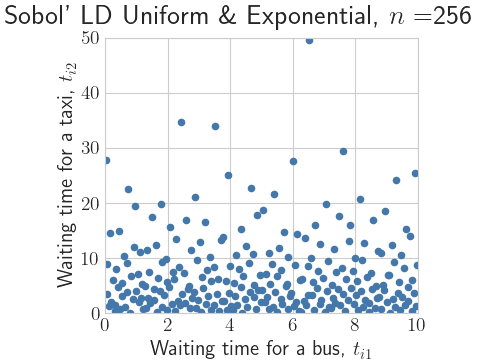

In [19]:
for key in keys_to_plot:
    s = the_samplers[key] 
    # Wrap the base sampler in a disribution whose first coordinate is uniform and second is exponential
    my_dist = qp.SciPyWrapper(s["gen"], scipy_distribs=[stats.uniform(loc=0,scale=10),stats.expon(scale=7)])

    fig, ax = qp.plot_proj(
        my_dist,
        n=n,
        d_horizontal=1,
        d_vertical=2,
        axis_pad=0.05,
        marker_size=20,
        figfac=4,  # how big do you want your figures
        fig_title=f"{s['label']} Uniform \& Exponential, $n=${n}",
        where_title=0.93,
    )
    ax[0,0].set_xlim([0,10])
    ax[0,0].set_ylim([0,50])
    ax[0,0].set_xlabel(r"Waiting time for a bus, $t_{i1}$")
    ax[0,0].set_ylabel(r"Waiting time for a taxi, $t_{i2}$")

## 3. Integrands: `CustomFun` and built‑in classes

An `Integrand` represents the function whose expectation we want to estimate.

- `qp.CustomFun(true_measure, custom_fun=...)` lets you plug in any Python function.
- Built‑in integrands (e.g. `Keister`, `AsianOption`, `EuropeanOption`, etc.) wrap common test problems and finance models.

We'll start with a classic example: the Keister integral:
\begin{align*} 
\mu &= \int_{\reals^d} \cos(\norm{\vx}{2})\, \exp(-\norm{\vx}{2}^2)\,  \dif \vx \\
& = \int_{\reals^d} \pi^{d/2} \cos(\norm{\vx}{2})\, \frac{\exp(-\norm{\vx}{2}^2)}{\pi^{d/2}}\,  \dif \vx = \Ex_{\vX \sim \cn(\vzero,0.5 \mI)}[\pi^{d/2} \cos(\norm{\vX}{2})] \\
& = \int_{[0,1]^d} \pi^{d/2} \cos\bigl(\norm{(\Phi^{-1}(u_1), \ldots, \Phi^{-1}(u_d))}{2}/\sqrt{2}\bigr) \,   \dif \vu 
= \Ex_{\vU \sim \cu[0,1]^d}\bigl[\pi^{d/2} \cos(\norm{(\Phi^{-1}(U_1), \ldots, \Phi^{-1}(U_d))}{2}/\sqrt{2} \bigr) \bigr ] \\
\end{align*}

There are a few different ways to perform Monte Carlo simulation depending on how you define the integrand

In [21]:
# ---- Your Keister integrands ----
def KeisterG(x):  #integral as the expectation of a Gaussian random variable
    """x: n x d array, returns length-n vector."""
    d = x.shape[1]
    r = norm(x, axis=1)
    return np.pi**(d/2) * np.cos(r)

def KeisterU(x):  #integral as the expectation of a standard uniform random variable
    """x: n x d array, returns length-n vector in [0,1]^d."""
    d = x.shape[1]
    r = norm(stats.norm.ppf(x), axis=1) / np.sqrt(2)
    return np.pi**(d/2) * np.cos(r)

Keister_choices = {  # these are integrands we will use
    "built-in":     lambda d, sampler: {
        "itgnd": qp.Keister(sampler(d)),
        "label": "Built-in qp.Keister",
    },
    "custom-gauss": lambda d, sampler: {
        "itgnd": qp.CustomFun(qp.Gaussian(sampler(d),covariance=1/2), g=KeisterG),
        "label": "Custom KeisterG",
    },
    "custom-unif":  lambda d, sampler: {
        "itgnd": qp.CustomFun(qp.Uniform(sampler(d)), g=KeisterU),
        "label": "Custom KeisterU",
    },
}

sampler_choices = {
    "IID uniform": qp.IIDStdUniform,  # plain Monte Carlo
    "Sobol'":      qp.Sobol,          # low-discrepancy Sobol'
    "Lattice":     qp.Lattice,        # low-discrepancy Lattice
}

# ---- Parameters ----
d = 5
n = 2**20

# Exact Keister value (same for all integrands here)
exact = qp.Keister(qp.Sobol(d)).exact_integ(d)
print(f"Exact answer = {exact:.6g}")


def fmt_one_line(mean, err):  #helper to format table
    return f"{mean: .6f} ({err:+.2e})"
rows = []
for s_name, sampler_ctor in sampler_choices.items():  #create a data table
    row = {"sampler": s_name}
    for k_name, builder in Keister_choices.items():
        itgnd = builder(d, sampler_ctor)["itgnd"]
        y = itgnd(n)
        mc = np.mean(y)
        err = mc - exact
        row[k_name] = fmt_one_line(mc, err)
    rows.append(row)
df = pd.DataFrame(rows).set_index("sampler")
print(df)

Exact answer = 1.13532
                          built-in           custom-gauss            custom-unif
sampler                                                                         
IID uniform   1.137802 (+2.48e-03)   1.136563 (+1.24e-03)   1.139720 (+4.40e-03)
Sobol'        1.135328 (+4.38e-06)   1.135332 (+8.21e-06)   1.135307 (-1.73e-05)
Lattice       1.135323 (-1.28e-06)   1.135330 (+6.17e-06)   1.135316 (-7.64e-06)


## 4. Stopping criteria

QMCPy separates *what* to integrate (the `Integrand`) from *how long* to integrate (the `StoppingCriterion`).

A stopping criterion object

- takes an integrand and user‑specified tolerances (absolute and/or relative),
- repeatedly requests more samples from the underlying distribution,
- stops once the estimated error is within tolerance.

Some commonly used classes are:

- `qp.CubMCCLT` – IID Monte Carlo with Central Limit Theorem error bounds
- `qp.CubMCG` – IID Monte Carlo with guaranteed error bounds based on Berry-Esseen Inequalities
- `qp.CubQMCSobolG` – QMC with Sobol' points
- `qp.CubQMCLatticeG` – QMC with lattice points

All share the same basic interface:

```python
stopper = qp.CubQMCSobolG(integrand, abs_tol=1e-3, rel_tol=0)
solution, data = stopper.integrate()
```

### 4.1 Help needed
Let's try stopping criteria on the Keister example above.  But first we need some helpers:
- The helper in the next cell collects the simulation data.
- The two helpers in the cell after that run the plots

In [22]:
def run_stopping_experiment(
    stoppers: Dict[str, Dict[str, Any]],
    make_integrand: Callable[[Any], Any],
    tols,
    n_max: int,
    exact_value: float | None = None,
    tol_type: str = "abs",   # or "rel"
    rel_tol: float = 0.0,
    proxy_factor: float = 1.1,
):
    """
    Run a stopping-criterion comparison experiment.

    Parameters
    ----------
    stoppers : dict
        e.g. {
          "MC-CLT":  {"sampler": qp.IIDStdUniform(d),
                     "SC": qp.CubMCCLT,
                     "proxy_attr": "bound_diff"},
          "Sobol'":  {"sampler": qp.Sobol(d),
                     "SC": qp.CubQMCSobolG,
                     "proxy_attr": "comb_bound_diff"},
          ...
        }
    make_integrand : callable
        Function taking a sampler and returning a QMCPy integrand object,
        e.g. `lambda sampler: qp.Keister(sampler)`.
    tols : array-like
        Absolute tolerances to test.
    tol_type: str
        What kind of tolerance we want
    n_max : int
        Maximum sample budget for the stopping criteria (n_max / n_limit).
    exact_value : float or None
        Exact value of the integral (if known). If None, `ans_correct`
        will stay NaN.
    rel_tol : float
        Relative tolerance to pass to the stopping criteria.
    proxy_factor : float
        Factor multiplying tol for the proxy check (e.g. error_width <= 1.1*tol).

    Returns
    -------
    results : dict with keys:
        "tols", "labels", "n_required", "time_required",
        "ans_correct", "think_correct", "hit_cap".
    """
    tols = np.asarray(tols, dtype=float)
    n_sc = len(stoppers)
    n_tol = len(tols)

    n_required    = np.full((n_sc, n_tol), np.nan)
    time_required = np.full((n_sc, n_tol), np.nan)
    # use float with NaN so we can signal "not available" when exact_value is None
    ans_correct   = np.full((n_sc, n_tol), np.nan)
    think_correct = np.zeros((n_sc, n_tol), dtype=bool)
    hit_cap       = np.zeros((n_sc, n_tol), dtype=bool)
    sol_estimates = np.full((n_sc, n_tol), np.nan)
    err_width = np.full((n_sc, n_tol), np.nan)

    if tol_type == "abs": #which kind of tolerance are we using
        tol_to_pair = lambda t: (t, 0.0)
    elif tol_type == "rel":
        tol_to_pair = lambda t: (0.0, t)
    else:
        raise ValueError("tol_type must be 'abs' or 'rel'")

    labels = list(stoppers.keys())

    for i, (label, entry) in enumerate(stoppers.items()):
        sampler    = entry["sampler"]
        SC         = entry["SC"]
        proxy_attr = entry["proxy_attr"]

        with tqdm(total=n_tol, desc=f"{label} stopping rule", unit="tol") as pbar:
            for j, tol in enumerate(tols):
                abs_tol, rel_tol = tol_to_pair(tol)
                sc = SC(
                    make_integrand(sampler),
                    abs_tol=tol,
                    rel_tol=rel_tol,
                    n_limit=n_max,     # change to n_limit=n_max if your QMCPy version wants that
                )
                sol, data = sc.integrate()
                sol_estimates[i, j] = sol

                # basic data
                n_required[i, j]    = float(data.n_total)
                time_required[i, j] = float(data.time_integrate)
                hit_cap[i, j]       = (data.n_total >= n_max)

                # true correctness (if exact value known)
                if exact_value is not None:
                    err = abs(sol - exact_value)
                    ans_correct[i, j] = float(err <= tol)

                # proxy correctness via error bound / proxy
                err_proxy = getattr(data, proxy_attr)/2.
                err_width[i, j] = err_proxy
                think_correct[i, j] = (err_proxy <= tol*proxy_factor)

                pbar.update(1)

    return {
        "tols": tols,
        "labels": labels,
        "sol": sol_estimates,
        "ci_width": err_width,
        "n_required": n_required,
        "time_required": time_required,
        "ans_correct": ans_correct,
        "think_correct": think_correct,
        "hit_cap": hit_cap,
    }

In [23]:
def overlay_status(ax, x, y, ans_row, think_row, cap_row):
    """
    ax        -- axis on which to overlay
    x, y      -- tolerance array and y-values
    ans_row   -- row with true correctness (can be bool or 0/1/NaN)
    think_row -- boolean row: proxy correctness
    cap_row   -- boolean row: hit sample cap
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # --- Normalize types ---
    ans_row   = np.asarray(ans_row)
    think_row = np.asarray(think_row, dtype=bool)
    cap_row   = np.asarray(cap_row, dtype=bool)

    # Turn numeric ans_row (0/1/NaN) into bool mask + "known" mask
    if ans_row.dtype != bool:
        ans_float = ans_row.astype(float)
        known = ~np.isnan(ans_float)
        ans_bool = np.zeros_like(known, dtype=bool)
        ans_bool[known] = ans_float[known] > 0.5
        ans_row = ans_bool
    else:
        known = np.ones_like(ans_row, dtype=bool)

    if np.any(known):
        # --------------------------------------------------
        # Mode 1: exact value known somewhere (Keister, etc.)
        # --------------------------------------------------
        success     =  known &  ans_row & ~cap_row
        fail_cap    =  known & ~ans_row &  cap_row
        fail_nocap  =  known & ~ans_row & ~cap_row
        met_and_cap =  known &  ans_row &  cap_row

        # A. RED square: failed tolerance AND hit cap
        if np.any(fail_cap):
            ax.scatter(
                x[fail_cap], y[fail_cap],
                facecolors="none", edgecolors="red",
                marker="s", s=100, linewidths=1.5,
            )

        # B. ORANGE X: failed tolerance but did NOT hit cap
        if np.any(fail_nocap):
            ax.scatter(
                x[fail_nocap], y[fail_nocap],
                c="orange", marker="x",
                s=80, linewidths=2,
            )

        # C. GREEN square: met tolerance but hit cap
        if np.any(met_and_cap):
            ax.scatter(
                x[met_and_cap], y[met_and_cap],
                facecolors="none", edgecolors="green",
                marker="s", s=100, linewidths=1.5,
            )

        # D. PURPLE circle: proxy disagrees with truth (only where truth is known)
        mismatch = (ans_row != think_row) & known
        if np.any(mismatch):
            ax.scatter(
                x[mismatch], y[mismatch],
                facecolors="none", edgecolors="purple",
                marker="o", s=150, linewidths=2,
            )

    else:
        # --------------------------------------------------
        # Mode 2: no exact value available (Asian arithmetic)
        # interpret everything via proxy + cap
        # --------------------------------------------------
        proxy_good        =  think_row & ~cap_row
        proxy_bad_cap     = ~think_row &  cap_row
        proxy_bad_nocap   = ~think_row & ~cap_row
        proxy_good_cap    =  think_row &  cap_row

        # RED square: proxy says "bad" AND hit cap
        if np.any(proxy_bad_cap):
            ax.scatter(
                x[proxy_bad_cap], y[proxy_bad_cap],
                facecolors="none", edgecolors="red",
                marker="s", s=100, linewidths=1.5,
            )

        # ORANGE X: proxy says "bad" and no cap
        if np.any(proxy_bad_nocap):
            ax.scatter(
                x[proxy_bad_nocap], y[proxy_bad_nocap],
                c="orange", marker="x",
                s=80, linewidths=2,
            )

        # GREEN square: proxy says "good" but hit cap
        if np.any(proxy_good_cap):
            ax.scatter(
                x[proxy_good_cap], y[proxy_good_cap],
                facecolors="none", edgecolors="green",
                marker="s", s=100, linewidths=1.5,
            )

        # (We usually don't overlay anything for proxy_good & no cap;
        # the base markers already show those points.)
        
import matplotlib.lines as mlines

# Proxy artists for diagnostics legend
red_square = mlines.Line2D([], [], 
                           color='red', marker='s', linestyle='none',
                           markersize=10, markerfacecolor='none',
                           label='fail tol \& hit cap')

orange_x = mlines.Line2D([], [], 
                         color='orange', marker='x', linestyle='none',
                         markersize=10, 
                         label='fail tol \& did NOT hit cap')

green_square = mlines.Line2D([], [], 
                             color='green', marker='s', linestyle='none',
                             markersize=10, markerfacecolor='none',
                             label='met tol \& hit cap')

purple_circle = mlines.Line2D([], [], 
                              color='purple', marker='o', linestyle='none',
                              markersize=10, markerfacecolor='none',
                              label='proxy disagrees with truth')


In [24]:
# ==========================================
# Side-by-side plots: n_required and time_required
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

def plot_stopping_side_by_side(
    tols,
    labels,
    n_required,
    time_required,
    ans_correct,
    think_correct,
    hit_cap,
    d,
    title_prefix="",
):
    """
    Make side-by-side log-log plots of required n and wall-clock time
    for a set of stopping rules.

    Parameters
    ----------
    tols : 1D array-like
        Absolute tolerances.
    labels : list of str
        One label per stopping rule, in the same order as the rows of the arrays.
    n_required, time_required : 2D arrays (n_rules x n_tols)
    ans_correct, think_correct, hit_cap : same shape
    d : int
        Dimension, used in title.
    title_prefix : str, optional
        Extra string to prepend in figure titles (e.g. "Keister").
    """
    tols = np.asarray(tols)
    n_rules = len(labels)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # ---------- Left plot: n required ----------
    ax = axs[0]
    for i in range(n_rules):
        label = labels[i]
        ax.plot(
            tols,
            n_required[i, :],
            marker="o",
            linestyle="none",
            label=label,
        )
        overlay_status(
            ax,
            tols,
            n_required[i, :],
            ans_correct[i, :],
            think_correct[i, :],
            hit_cap[i, :],
        )
    ax.set_ylabel(r"sample size required $n$")
    if title_prefix:
        ax.set_title(f"{title_prefix}: required n (d = {d})")
    else:
        ax.set_title(f"Required n (d = {d})")
    ax.legend(loc="lower left")

    # ---------- Right plot: time required ----------
    ax = axs[1]
    for i in range(n_rules):
        label = labels[i]
        ax.plot(
            tols,
            time_required[i, :],
            marker="o",
            linestyle="none",
            label=label,
        )
        overlay_status(
            ax,
            tols,
            time_required[i, :],
            ans_correct[i, :],
            think_correct[i, :],
            hit_cap[i, :],
        )
    ax.set_ylabel("time (s)")
    ax.set_title("Wall-clock time")

    # ---------- Shared axis formatting ----------
    for ax in axs:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"absolute tolerance $\varepsilon$")

    plt.tight_layout()

    # ---------- Diagnostics Legend ----------
    # assumes red_square, orange_x, green_square, purple_circle are defined globally
    fig.legend(
        handles=[red_square, orange_x, green_square, purple_circle],
        loc="lower center",
        ncol=2,
        frameon=False,
        fontsize=10,
    )
    plt.subplots_adjust(bottom=0.25)

    plt.show()
    return fig, axs

### 4.2 Running the Keister example

In [25]:
# dimension
d = 6

# integrand factory
make_keister = lambda sampler: qp.Keister(sampler)

# exact value using Sobol' (as you had)
exact_keister = qp.Keister(qp.Sobol(d)).exact_integ(d)

# stoppers
stoppers_keister = {
    "MC-CLT":  {"sampler": qp.IIDStdUniform(d), "SC": qp.CubMCCLT,       "proxy_attr": "bound_diff"},
    "Sobol'":  {"sampler": qp.Sobol(d),         "SC": qp.CubQMCSobolG,   "proxy_attr": "comb_bound_diff"},
    "Lattice": {"sampler": qp.Lattice(d),       "SC": qp.CubQMCLatticeG, "proxy_attr": "comb_bound_diff"},
}

tols  = np.array([5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3])
n_max = 2**28

results_keister = run_stopping_experiment(
    stoppers=stoppers_keister,
    make_integrand=make_keister,
    tols=tols,
    n_max=n_max,
    exact_value=exact_keister,
)

# Pull out arrays for plotting
n_required_keister    = results_keister["n_required"]
time_required_keister = results_keister["time_required"]
ans_correct_keister   = results_keister["ans_correct"]
think_correct_keister = results_keister["think_correct"]
hit_cap_keister       = results_keister["hit_cap"]
labels_keister        = results_keister["labels"]

MC-CLT stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/stopping_criterion/cub_mc_clt.py:227: MaxSamplesWarning: 
            Already generated 1024 samples.
            Trying to generate 427600903 new samples would exceed n_limit = 268435456.
            Will instead generate 268434432 new samples to reach n_limit.
  warnings.warn(warning_s, MaxSamplesWarning)
/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/stopping_criterion/cub_mc_clt.py:227: MaxSamplesWarning: 
            Already generated 1024 samples.
            Trying to generate 1856198594 new samples would exceed n_limit = 268435456.
            Will instead generate 268434432 new samples to reach n_limit.
  warnings.warn(warning_s, MaxSamplesWarning)


Sobol' stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

Lattice stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

The exact value of the Keister integral = -2.3273


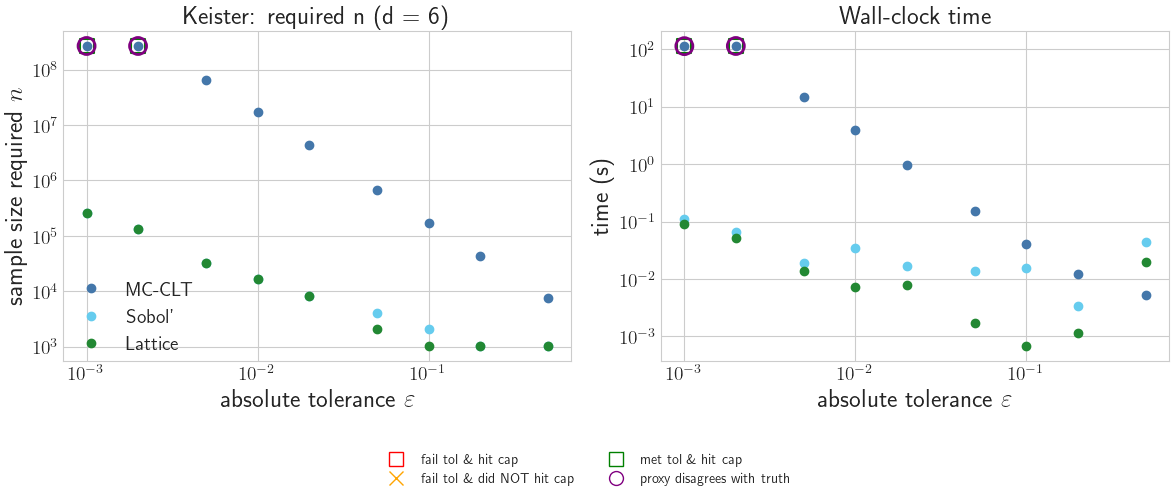

In [26]:
print(f"The exact value of the Keister integral = {exact_keister:.5g}")

labels = list(stoppers_keister.keys())  # same order as stoppers.items()

fig, axs = plot_stopping_side_by_side(
    tols=tols,
    labels=labels,
    n_required=n_required_keister,
    time_required=time_required_keister,
    ans_correct=ans_correct_keister,
    think_correct=think_correct_keister,
    hit_cap=hit_cap_keister,
    d=d,
    title_prefix="Keister",
)

In [27]:
cl.nbviz.note_md(r"""
Note that

- All stopping criteria assume that the integrand, $f$, is **nice** in some technical way, which allows it to compute a data-based proxy for the error.  
- There is typically **no way to know** whether these technical assumptions are satisfied a priori.  
- So the stopping criterion might stop **before** the error criterion is truly satisfied. 
- If you rerun the data, you may get different results.  All of these algorithms are random.

From the plots above we observe that

- The stopping criterion using the Central Limit Theorem (CLT) for IID Monte Carlo sometimes **does not yield 
an accurate confidence interval**
    - Because confidence intervals do not hold 100% of the time or 
    - Because the variance was not accurately estimated by the sample variance, which would happen if $f$ had a large kurtosis.
- **LD sampling beats** IID sampling in terms of speed.
- The computational burden of LD sampling grows **more slowly** than IID sampling. 
""")

## 5. Asian option pricing

QMCPy includes several integrands that are the payoffs of Asian style options.  These are contained in `qmcpy/integrand/financial_options`. Here we use the `FinancialOption` integrand to price an arithmetic‑mean call option on a geometric Brownian motion.

We'll compare:

- IID Monte Carlo (`CubMCCLT` with `IIDStdUniform`),
- Sobol' QMC (`CubQMCSobolG` with `Sobol`).

The next cell computes the data, and the one after plots it.

In [28]:
# Dimension of the Brownian path (number of monitoring times)
d_path = 52   #number of weeks in a year

def make_asian_arith_call(sampler):  #defining the option
    return qp.FinancialOption(
        sampler=sampler,  #a DiscreteDistribution
        option="ASIAN",
        call_put="CALL",
        volatility=0.5,
        start_price=30,
        strike_price=35,
        interest_rate=0.02,
        t_final=1.0,
        decomp_type="PCA",
        asian_mean="ARITHMETIC",
        asian_mean_quadrature_rule="TRAPEZOIDAL",
    )

# stoppers
stoppers_asian = {
    "MC-CLT":  {"sampler": qp.IIDStdUniform(d_path), "SC": qp.CubMCCLT,       "proxy_attr": "bound_diff"},
    "Sobol'":  {"sampler": qp.Sobol(d_path),         "SC": qp.CubQMCSobolG,   "proxy_attr": "comb_bound_diff"},
    "Lattice": {"sampler": qp.Lattice(d_path),       "SC": qp.CubQMCLatticeG, "proxy_attr": "comb_bound_diff"},
}

tols  = np.array([5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3])
n_max = 2**23

results_asian = run_stopping_experiment(
    stoppers=stoppers_asian,
    make_integrand=make_asian_arith_call,
    tols=tols,
    tol_type="abs",  #change to "rel" for relative error
    n_max=n_max,
    exact_value=None,   # <- no closed-form value here
)

MC-CLT stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/stopping_criterion/cub_mc_clt.py:227: MaxSamplesWarning: 
            Already generated 1024 samples.
            Trying to generate 53373247 new samples would exceed n_limit = 8388608.
            Will instead generate 8387584 new samples to reach n_limit.
  warnings.warn(warning_s, MaxSamplesWarning)
/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/stopping_criterion/cub_mc_clt.py:227: MaxSamplesWarning: 
            Already generated 1024 samples.
            Trying to generate 242893267 new samples would exceed n_limit = 8388608.
            Will instead generate 8387584 new samples to reach n_limit.
  warnings.warn(warning_s, MaxSamplesWarning)


Sobol' stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

Lattice stopping rule:   0%|          | 0/9 [00:00<?, ?tol/s]

We do not know the exact answer, but the option price approximated by Sobol' is 1.86052 +/- 0.001


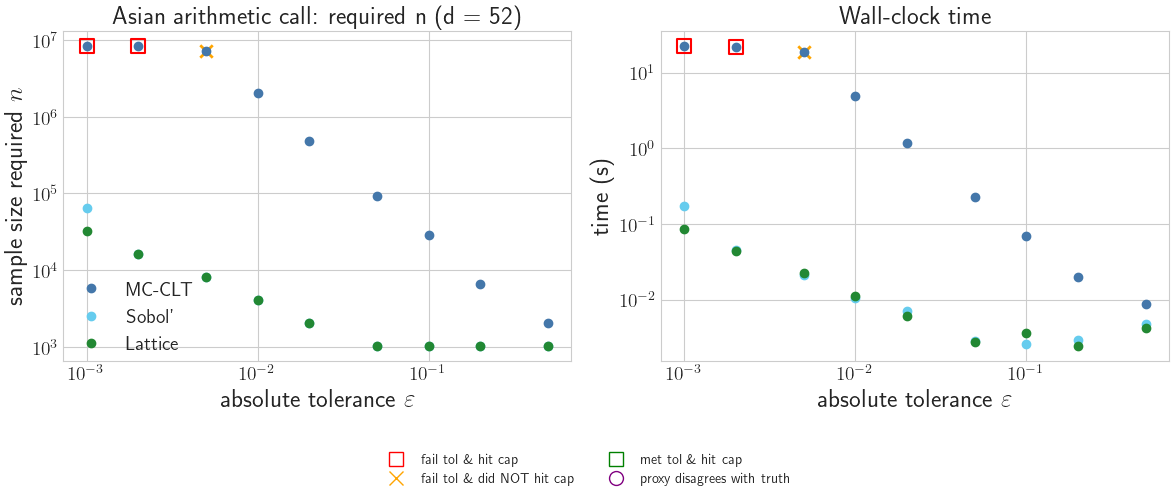

In [29]:
print(f"We do not know the exact answer, but the option price approximated by Sobol' is"
      f" {results_asian["sol"][labels.index("Sobol'"), -1]:.6g} +/- {float(tols[-1]):g}")

n_required_asian    = results_asian["n_required"]
time_required_asian = results_asian["time_required"]
ans_correct_asian   = results_asian["ans_correct"]     # all NaN; overlay_status handles this
think_correct_asian = results_asian["think_correct"]
hit_cap_asian       = results_asian["hit_cap"]
labels_asian        = results_asian["labels"]

fig, axs = plot_stopping_side_by_side(
    tols=tols,
    labels=labels_asian,
    n_required=n_required_asian,
    time_required=time_required_asian,
    ans_correct=ans_correct_asian,
    think_correct=think_correct_asian,
    hit_cap=hit_cap_asian,
    d=d_path,
    title_prefix="Asian arithmetic call",
)

In [30]:
print(tols)
print(results_asian["ci_width"][0,:])

[0.5   0.2   0.1   0.05  0.02  0.01  0.005 0.002 0.001]
[0.41936496 0.20463943 0.08943315 0.04956892 0.0212083  0.01040189
 0.00552241 0.00512862 0.00512517]


## 6. Variance or variation reduction:

`qmcpy` has support for importance sampling and control variates.  Let me invite you to explore these on your own.